In [3]:
import numpy as np
import os
import re
import cv2
import math
from numpy import all, any, array, arctan2, cos, sin, exp, dot, log, logical_and, roll, sqrt, stack, trace, unravel_index, pi, deg2rad, rad2deg, where, zeros, floor, full, nan, isnan, round, float32
from numpy.linalg import det, lstsq, norm
from functools import cmp_to_key

%matplotlib inline

import cv2
from matplotlib import pyplot as plt

DISCLAIMER

This code is HEAVILY inspired by R. Islam's implementation due to the SIFT method being quite involved and maths heavy. This project focuses mainly on increasing my understanding of the SIFT algorithm and being able to apply it to a problem of my choosing.  

The code I am basing much of this on can be found over at Islam's Github:
        https://github.com/rmislam/PythonSIFT/blob/master/pysift.py

Alot of the code here can be very similar as I have followed his guide for SIFT implementation in python.

Other important resources have been:

-   The original SIFT paper (Lowe): 
        https://www.cs.ubc.ca/~lowe/papers/ijcv04.pdf

-   Walkthrough of the SIFT algorithm (Prof. Dr. Edmund Weitz): 
        http://weitz.de/sift/

-   Easy to follow SIFT walkthrough (Utkarsh Sinha): 
        https://aishack.in/tutorials/sift-scale-invariant-feature-transform-keypoint-orientation/

-   Anatomy of the SIFT method(Ives Rey-Otero, Mauricio Delbracio):
        https://www.ipol.im/pub/art/2014/82/article_lr.pdf

In [4]:
# Open image and convert it to float32 for handling later
path = "eiffel_test.jpg" #"./eiffel_test.jpg"
image1 = cv2.imread("splits/eiffel_test/eiffel_test_1_1.jpg", 0) #grayscale to normalize the color values
image2 = cv2.imread(path, 0)
im1 = image1.astype("float32")
im2 = image2.astype("float32")
print(im1.shape)
print(im2.shape)


(355, 213)
(1066, 640)


In [5]:
# Generate seed image as baseline for further Gaussian convolutions
# According to the original SIFT-paper, this seed image should be an upsampling by a factor of 2
# To do this we use bilinear interpolation on the input image
im1 = cv2.resize(im1, (0,0), fx=2, fy=2, interpolation=cv2.INTER_LINEAR)
im2 = cv2.resize(im2, (0,0), fx=2, fy=2, interpolation=cv2.INTER_LINEAR)

# Use minimum sigma devised from SIFT paper (0.8)
# The original sigma is set to be 0.5 since the original image is
# upscaled by a factor of 2 to create the seed image. Hence the "upscaling" of the sigmas by a factor of 2 as well
sigma = 1.6
sigma_diff = sqrt((sigma)**2 - (2*0.5)**2)
float_tolerance = 1e-7 # For floating point estimation
n_scales_octave = 3
n_img_octave = n_scales_octave + 3

im1 = cv2.GaussianBlur(im1, (0, 0), sigmaX=sigma_diff, sigmaY=sigma_diff)
im2 = cv2.GaussianBlur(im2, (0, 0), sigmaX=sigma_diff, sigmaY=sigma_diff)


In [6]:
# Generate scale space
# https://www.ipol.im/pub/art/2014/82/article_lr.pdf

# To generate the scale space, we first need to know how many times we can downsample the image before it is too small for our calculations of local extrema. (This requires a neighborhood of at least 9 pixels. 3x3)
def find_num_octaves(image):
    smallest_dim = min(image.shape)
    num_octaves = math.floor(math.log(smallest_dim, 2))
    num_octaves = num_octaves if smallest_dim/2**num_octaves >= 3 else num_octaves-1 # Check if image too small

    return num_octaves

num_octaves1 = find_num_octaves(im1)
num_octaves2 = find_num_octaves(im2)

In [7]:
# Create scale space images and blur them
# I have chosen to use 3 scales per octave
# Meaning I need 6 images per octave since the first and last scales also require images to compute DoG

def get_gaussian_kernels(sig):
    k = 2**(1./n_scales_octave) # k is the space / size of the interval between subsequent images / scales in an octave.
    kernels = np.zeros(n_img_octave)
    kernels[0] = sig

    for i in range(1, n_img_octave):
        sig_total = k*sig
        kernels[i] = sqrt(sig_total**2 - sig**2)
        sig = sig_total

    return kernels

#print(get_gaussian_kernels(sigma))


In [8]:
def generate_octaves(img, g_kernels, num_octaves):
    blurred_images = []

    for i in range(num_octaves):
        octave_images = []
        octave_images.append(img)

        for kernel in g_kernels[1:]:
            blurred_img = cv2.GaussianBlur(img, (0, 0), sigmaX=kernel, sigmaY=kernel)
            octave_images.append(blurred_img)
        blurred_images.append(octave_images)


        # The next octave will have the third to last image in the current octave as it's base.
        # This is because of the way we calculate the scaling factor k used to apply blur to the images. (k = 2**(1/scales_per_octave))
        next_base = octave_images[-3]
        img = cv2.resize(next_base, (int(next_base.shape[1]/2), int(next_base.shape[0]/2)), interpolation=cv2.INTER_NEAREST) 

    return np.array(blurred_images)

kernels = get_gaussian_kernels(sigma)
blurs1 = generate_octaves(im1, kernels, num_octaves1)
blurs2 = generate_octaves(im2, kernels, num_octaves2)

C:\Users\Jonas\AppData\Local\Temp\ipykernel_24292\2562940764.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(blurred_images)


In [9]:
# Visualization
def visualize(img_array):
    # Visualize a row of images
    n_images = len(img_array)
    #print(n_octaves, n_images)

    f = plt.figure(figsize=(30,30))
    for i in range(n_images):
        f.add_subplot(1, n_images, i+1)
        plt.imshow(img_array[i], cmap="gray")

    plt.show()

C:\Users\Jonas\AppData\Local\Temp\ipykernel_24292\1737022858.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(dog_images)


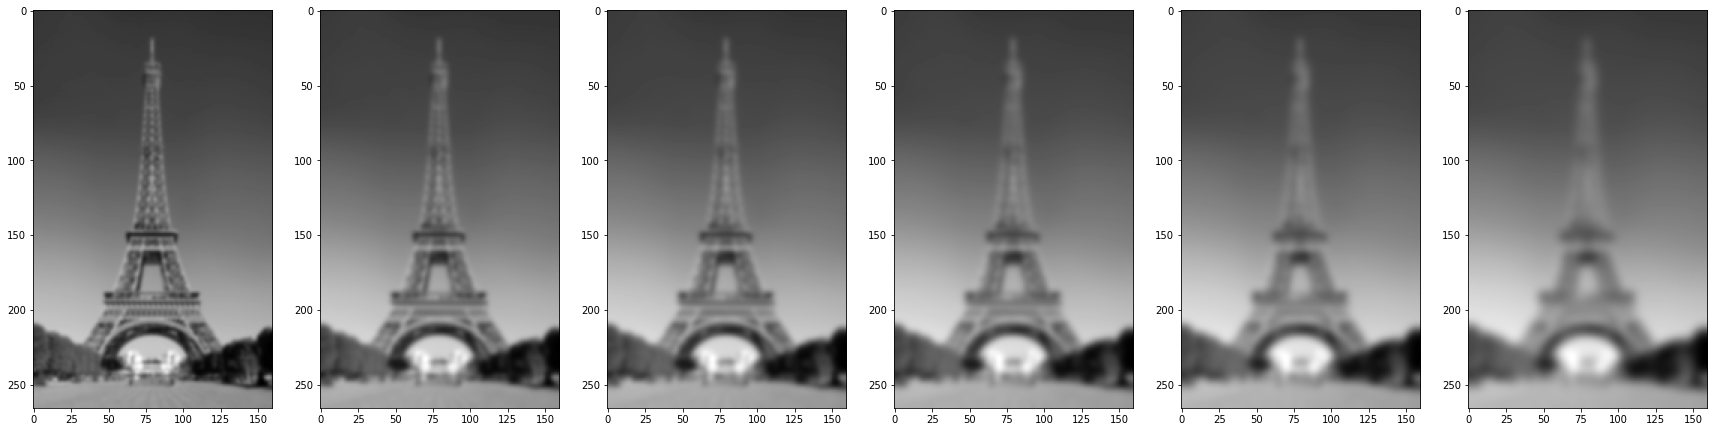

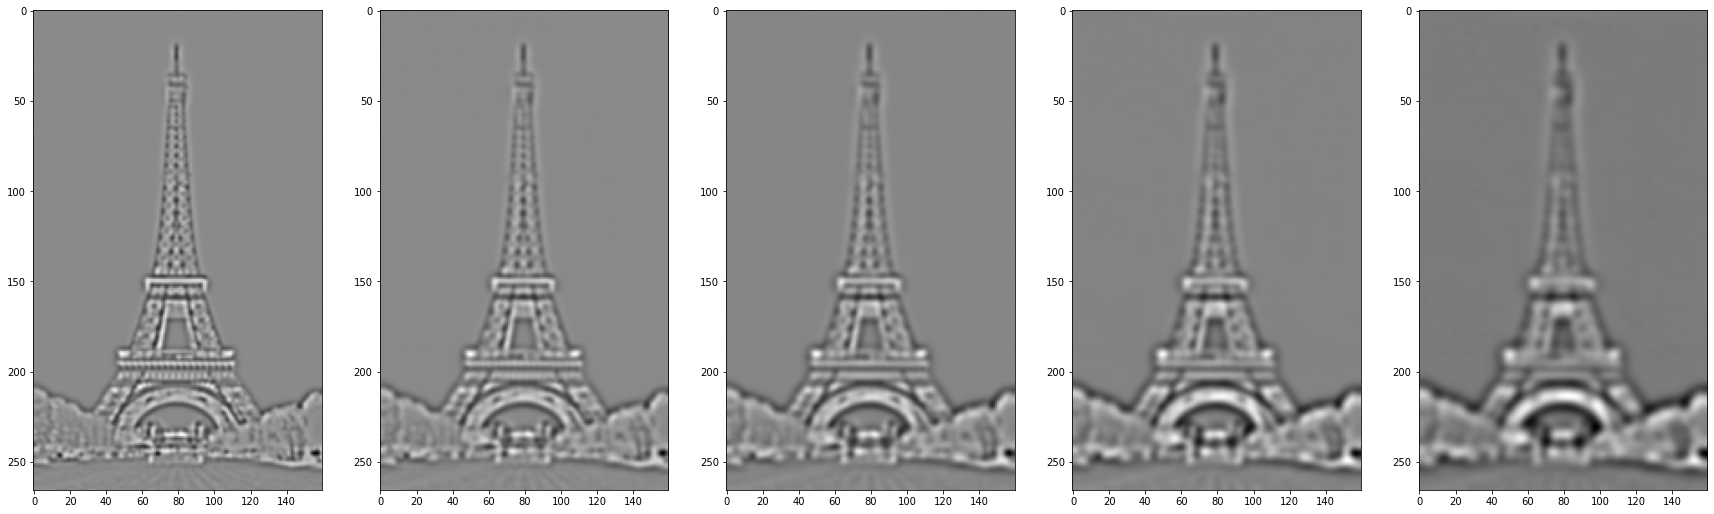

In [10]:
# Calculate the difference of gaussian images
def difference_of_gaussians(gaussian_images):
    dog_images = [] # dog for difference of gaussian, not actually images of dogs :)

    for octave in gaussian_images:
        dog_imgs_octave = []
        for i in range(1,len(octave)):
            dog_img = cv2.subtract(octave[i], octave[i-1])
            dog_imgs_octave.append(dog_img)

        dog_images.append(dog_imgs_octave)
    
    return np.array(dog_images)

dog_imgs1 = difference_of_gaussians(blurs1)
dog_imgs2 = difference_of_gaussians(blurs2)
visualize(blurs2[3])
visualize(dog_imgs2[3])

In [11]:
# From these difference of gaussian images, we wish to find candidates for key points.
# This is done by finding scale-space extrema, be it maxima or minima.
# We do this by comparing each pixel to it's neighboring pixels in a 3x3 grid.
# This neighborhood also includes 3x3 grids in the scales above and below the current one.
# This is the reason why we included 3 extra images on top of the original choice of n_scales.
# We also filter away extrema that may fall below a certain threshold, since these may just be caused by random noise.


# First we'll start by checking if a pixel is a local extremum
contrast_threshold = 0.04
threshold = math.floor(0.5 * contrast_threshold / n_scales_octave * 255)
def is_local_extremum(tile1, tile2, tile3):
    px_abs_val = abs(tile2[1,1])

    # Check if pixel value is sufficiently "distinct" to try to combat noise
    if px_abs_val > threshold:
        # Then check if the pixel value is greater than all other surrounding pixel values.
        # Only checking for the absolute value, since we just care if it is an extremum, not what kind.
        return all(px_abs_val >= abs(tile1)) and all(px_abs_val >= abs(tile2)) and all(px_abs_val >= abs(tile3))
    
    return False


""" 
If a pixel is a local extremum, we have to find it's location. We have to do this because alot of the extrema might actually not be situated exactly on top of a pixel, they're more likely to be located in sub-pixel locations, meaning we will have to approximate their actual location. This is done via quadratic fit optimization.
"""
def localize_extremum_via_quadratic_fit(i, j, img_i, octave_i, dog_imgs_octave, border_w, eigenvalue_ratio=10, n_attempts=5):

    img_shape = dog_imgs_octave[0].shape
    #print(dog_imgs_octave.shape, ", ", img_shape)
    #print(img_i)

    for attempt in range(n_attempts):
        first_img, second_img, third_img = dog_imgs_octave[img_i-1:img_i+2]
        cube = stack([first_img[i-1:i+2, j-1:j+2],
                      second_img[i-1:i+2, j-1:j+2],
                      third_img[i-1:i+2, j-1:j+2]]).astype('float32') / 255.
        
        # Find gradient to find edges in img
        dx = 0.5 * (cube[1, 1, 2] - cube[1, 1, 0])
        dy = 0.5 * (cube[1, 2, 1] - cube[1, 0, 1])
        ds = 0.5 * (cube[2, 1, 1] - cube[0, 1, 1])
        gradient = np.array([dx, dy, ds])

        # Compute hessian to find corners, these are what we really want :)
        px_val = cube[1, 1, 1]

        dxx = cube[1, 1, 2] - 2 * px_val + cube[1, 1, 0]
        dyy = cube[1, 2, 1] - 2 * px_val + cube[1, 0, 1]
        dss = cube[2, 1, 1] - 2 * px_val + cube[0, 1, 1]
        dxy = 0.25 * (cube[1, 2, 2] - cube[1, 2, 0] - cube[1, 0, 2] + cube[1, 0, 0])
        dxs = 0.25 * (cube[2, 1, 2] - cube[2, 1, 0] - cube[0, 1, 2] + cube[0, 1, 0])
        dys = 0.25 * (cube[2, 2, 1] - cube[2, 0, 1] - cube[0, 2, 1] + cube[0, 0, 1])
        hessian = array([[dxx, dxy, dxs], [dxy, dyy, dys], [dxs, dys, dss]])

        position_update = -lstsq(hessian, gradient, rcond=None)[0]
        # Check if sufficient convergence has been met / satisfied. If under 0.5 change, means we have converged to changes of under a pixel and we can stop
        if all(abs(position_update) < 0.5):
            break

        # If not, continue iterating by updating x (j) and y (i) by the least squares solution
        j += int(round(position_update[0]))
        i += int(round(position_update[1]))
        img_i += int(round(position_update[2]))

        # Check that we are not out of bounds with new extrema location
        if i < border_w or i >= img_shape[0] - border_w or j < border_w or j >= img_shape[1] - border_w or img_i < 1 or img_i > n_scales_octave:
            return None
    #print(i, ", ", j)
    if attempt == n_attempts - 1:
        return None

    updated_value = cube[1, 1, 1] + 0.5 * dot(gradient, position_update)
    if abs(updated_value) * n_scales_octave >= contrast_threshold:
        xy_hessian = hessian[:2, :2]
        xy_hessian_trace = trace(xy_hessian)
        xy_hessian_det = det(xy_hessian)
        if xy_hessian_det > 0 and eigenvalue_ratio * (xy_hessian_trace ** 2) < ((eigenvalue_ratio + 1) ** 2) * xy_hessian_det:
            keypoint = cv2.KeyPoint()
            keypoint.pt = ((j + position_update[0]) * (2 ** octave_i), (i + position_update[1]) * (2 ** octave_i))
            keypoint.octave = octave_i + img_i * (2 ** 8) + int(round((position_update[2] + 0.5) * 255)) * (2 ** 16)
            keypoint.size = sigma * (2 ** ((img_i + position_update[2]) / float32(n_scales_octave))) * (2 ** (octave_i + 1))  # octave_index + 1 because the input image was doubled
            keypoint.response = abs(updated_value)
            return keypoint, img_i
    return None

After a location is found, we have to find the orientation of the keypoint to gain our final advantage of the SIFT-algorithm, rotation invariance. We use the orientation of the keypoint in following comparisons between keypoints to make matching possible. To do this we use the following formulae where m is the magnitude of the gradient at the keypoint, and theta is the orientation of the gradient:

![](gradient_mag_orientation.png)

Both of these formulae are pretty basic trigonometry, so they should be fine to compute :)

In [12]:

def compute_keypoints_with_orientations(keypoint, octave_i, gaussian_image, radius_factor=3, num_bins=36, peak_ratio=0.8, scale_factor=1.5):
    """
    A little explanation of the different variables:
    -   radius_factor: The base-radius of the square that we do computations on
    -   num_bins:      The amount of parts to divide degrees into. We have 10 degrees per bin -> num_bins=36
    -   scale_factor:  The amount we scaled the image for each octave

    """
    keypoints_with_orientations = []
    image_shape = gaussian_image.shape

    scale = scale_factor * keypoint.size / float32(2 ** (octave_i + 1))
    radius = int(round(radius_factor * scale))
    weight_factor = -0.5 / (scale ** 2)
    raw_histogram = zeros(num_bins)
    smooth_histogram = zeros(num_bins)

    for i in range(-radius, radius + 1):
        region_y = int(round(keypoint.pt[1] / float32(2 ** octave_i))) + i
        if region_y > 0 and region_y < image_shape[0] - 1:
            for j in range(-radius, radius + 1):
                region_x = int(round(keypoint.pt[0] / float32(2 ** octave_i))) + j
                if region_x > 0 and region_x < image_shape[1] - 1:
                    dx = gaussian_image[region_y, region_x + 1] - gaussian_image[region_y, region_x - 1]
                    dy = gaussian_image[region_y - 1, region_x] - gaussian_image[region_y + 1, region_x]
                    gradient_magnitude = sqrt(dx * dx + dy * dy)
                    gradient_orientation = rad2deg(arctan2(dy, dx))
                    weight = exp(weight_factor * (i ** 2 + j ** 2))  # constant in front of exponential can be dropped because we will find peaks later
                    histogram_index = int(round(gradient_orientation * num_bins / 360.))
                    raw_histogram[histogram_index % num_bins] += weight * gradient_magnitude

    for n in range(num_bins):
        smooth_histogram[n] = (6 * raw_histogram[n] + 4 * (raw_histogram[n - 1] + raw_histogram[(n + 1) % num_bins]) + raw_histogram[n - 2] + raw_histogram[(n + 2) % num_bins]) / 16.
    orientation_max = max(smooth_histogram)
    orientation_peaks = where(logical_and(smooth_histogram > roll(smooth_histogram, 1), smooth_histogram > roll(smooth_histogram, -1)))[0]
    for peak_index in orientation_peaks:
        peak_value = smooth_histogram[peak_index]
        if peak_value >= peak_ratio * orientation_max:
            # Quadratic peak interpolation
            # The interpolation update is given by equation (6.30) in https://ccrma.stanford.edu/~jos/sasp/Quadratic_Interpolation_Spectral_Peaks.html
            left_value = smooth_histogram[(peak_index - 1) % num_bins]
            right_value = smooth_histogram[(peak_index + 1) % num_bins]
            interpolated_peak_index = (peak_index + 0.5 * (left_value - right_value) / (left_value - 2 * peak_value + right_value)) % num_bins
            orientation = 360. - interpolated_peak_index * 360. / num_bins
            if abs(orientation - 360.) < float_tolerance:
                orientation = 0
            new_keypoint = cv2.KeyPoint(*keypoint.pt, keypoint.size, orientation, keypoint.response, keypoint.octave)
            keypoints_with_orientations.append(new_keypoint)
    return keypoints_with_orientations

In [13]:
def find_scale_space_extrema(gaussian_images, dog_images, border_w=5):
    keypoints = []

    for octave_i, dog_imgs_octave in enumerate(dog_images):
        for img_i in range(1, len(dog_imgs_octave)-1):
            first_img, second_img, third_img = dog_imgs_octave[img_i-1:img_i+2]

            # This nested for-loop checks every 3x3x3 box of pixels to detect local extrema.
            # If the pixel in question is not an extrema, we just move on to the next
            for i in range(border_w, first_img.shape[0] - border_w):
                for j in range(border_w, first_img.shape[1] - border_w):
                    if is_local_extremum(first_img[i-1:i+2, j-1:j+2], second_img[i-1:i+2, j-1:j+2], third_img[i-1:i+2, j-1:j+2]):
                        # If we have found a local extrema, we will have to localize it's exact (almost) position.
                        # This is due to the fact that extrema are most likely not at an exact whole pixel value, we are mostly dealing with sub-pixel locations in this step.
                        # This localization is done via a quadratic fit
                        loc_res = localize_extremum_via_quadratic_fit(i, j, img_i, octave_i, dog_imgs_octave, border_w)
                        if loc_res is not None:
                            # The keypoint at this location is valid and has passed all the checks
                            # Proceed by finding it's orientation
                            keypoint, loc_img_i = loc_res
                            keypoints_w_orientations = compute_keypoints_with_orientations(keypoint, octave_i, gaussian_images[octave_i][loc_img_i])
                            for k in keypoints_w_orientations:
                                keypoints.append(k)

    return keypoints

keypoints1 = find_scale_space_extrema(blurs1, dog_imgs1)
keypoints2 = find_scale_space_extrema(blurs2, dog_imgs2)

In [14]:

def convertKeypointsToInputImageSize(keypoints):
    """Convert keypoint point, size, and octave to input image size
    """
    converted_keypoints = []
    for keypoint in keypoints:
        keypoint.pt = tuple(0.5 * array(keypoint.pt))
        keypoint.size *= 0.5
        keypoint.octave = (keypoint.octave & ~255) | ((keypoint.octave - 1) & 255)
        converted_keypoints.append(keypoint)
    return converted_keypoints

def compareKeypoints(keypoint1, keypoint2):
    """Return True if keypoint1 is less than keypoint2
    """
    if keypoint1.pt[0] != keypoint2.pt[0]:
        return keypoint1.pt[0] - keypoint2.pt[0]
    if keypoint1.pt[1] != keypoint2.pt[1]:
        return keypoint1.pt[1] - keypoint2.pt[1]
    if keypoint1.size != keypoint2.size:
        return keypoint2.size - keypoint1.size
    if keypoint1.angle != keypoint2.angle:
        return keypoint1.angle - keypoint2.angle
    if keypoint1.response != keypoint2.response:
        return keypoint2.response - keypoint1.response
    if keypoint1.octave != keypoint2.octave:
        return keypoint2.octave - keypoint1.octave
    return keypoint2.class_id - keypoint1.class_id

def removeDuplicateKeypoints(keypoints):
    """Sort keypoints and remove duplicate keypoints
    """
    if len(keypoints) < 2:
        return keypoints

    keypoints.sort(key=cmp_to_key(compareKeypoints))
    unique_keypoints = [keypoints[0]]

    for next_keypoint in keypoints[1:]:
        last_unique_keypoint = unique_keypoints[-1]
        if last_unique_keypoint.pt[0] != next_keypoint.pt[0] or \
           last_unique_keypoint.pt[1] != next_keypoint.pt[1] or \
           last_unique_keypoint.size != next_keypoint.size or \
           last_unique_keypoint.angle != next_keypoint.angle:
            unique_keypoints.append(next_keypoint)
    return unique_keypoints

keypoints1 = removeDuplicateKeypoints(keypoints1)
keypoints1 = convertKeypointsToInputImageSize(keypoints1)
keypoints2 = removeDuplicateKeypoints(keypoints2)
keypoints2 = convertKeypointsToInputImageSize(keypoints2)

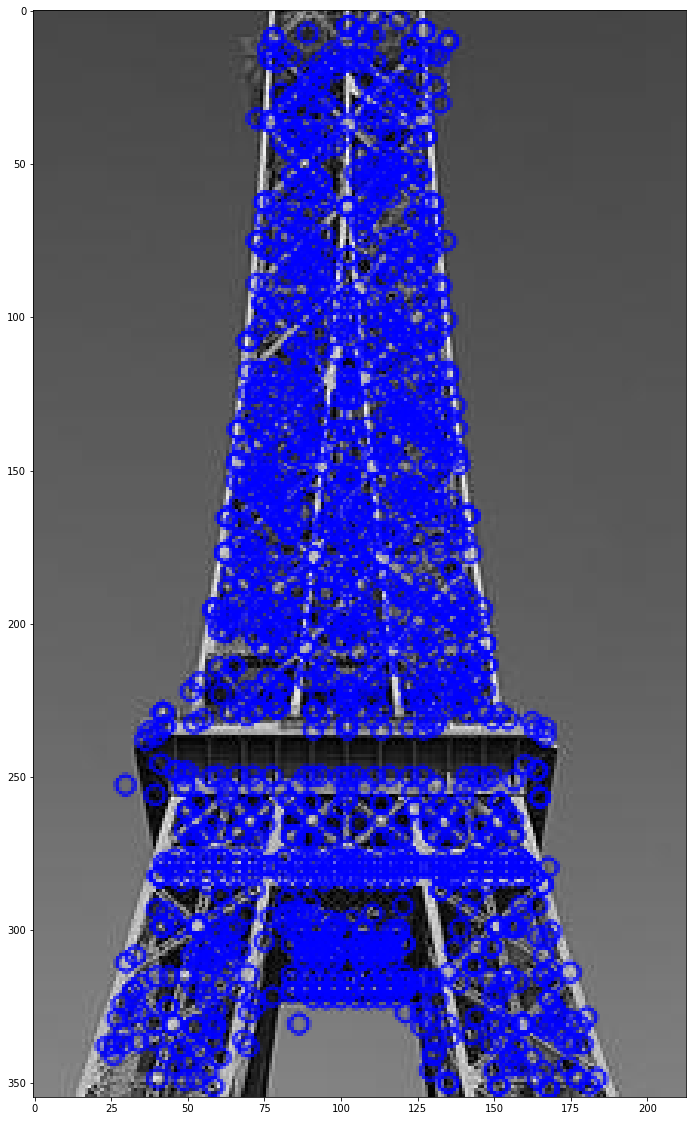

In [15]:

output_image = cv2.drawKeypoints(image1, keypoints1, 0, (0, 0, 255),
                                 flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(20,20))
plt.imshow(output_image)
plt.show()  

In [16]:
def unpackOctave(keypoint):
    """Compute octave, layer, and scale from a keypoint
    """
    octave = keypoint.octave & 255
    layer = (keypoint.octave >> 8) & 255
    if octave >= 128:
        octave = octave | -128
    scale = 1 / float32(1 << octave) if octave >= 0 else float32(1 << -octave)
    return octave, layer, scale

def generateDescriptors(keypoints, gaussian_images, window_width=4, num_bins=8, scale_multiplier=3, descriptor_max_value=0.2):
    """Generate descriptors for each keypoint
    """
    descriptors = []

    for keypoint in keypoints:
        octave, layer, scale = unpackOctave(keypoint)
        gaussian_image = gaussian_images[octave + 1, layer]
        num_rows, num_cols = gaussian_image.shape
        point = round(scale * array(keypoint.pt)).astype('int')
        bins_per_degree = num_bins / 360.
        angle = 360. - keypoint.angle
        cos_angle = cos(deg2rad(angle))
        sin_angle = sin(deg2rad(angle))
        weight_multiplier = -0.5 / ((0.5 * window_width) ** 2)
        row_bin_list = []
        col_bin_list = []
        magnitude_list = []
        orientation_bin_list = []
        histogram_tensor = zeros((window_width + 2, window_width + 2, num_bins))   # first two dimensions are increased by 2 to account for border effects

        # Descriptor window size (described by half_width) follows OpenCV convention
        hist_width = scale_multiplier * 0.5 * scale * keypoint.size
        half_width = int(round(hist_width * sqrt(2) * (window_width + 1) * 0.5))   # sqrt(2) corresponds to diagonal length of a pixel
        half_width = int(min(half_width, sqrt(num_rows ** 2 + num_cols ** 2)))     # ensure half_width lies within image

        for row in range(-half_width, half_width + 1):
            for col in range(-half_width, half_width + 1):
                row_rot = col * sin_angle + row * cos_angle
                col_rot = col * cos_angle - row * sin_angle
                row_bin = (row_rot / hist_width) + 0.5 * window_width - 0.5
                col_bin = (col_rot / hist_width) + 0.5 * window_width - 0.5
                if row_bin > -1 and row_bin < window_width and col_bin > -1 and col_bin < window_width:
                    window_row = int(round(point[1] + row))
                    window_col = int(round(point[0] + col))
                    if window_row > 0 and window_row < num_rows - 1 and window_col > 0 and window_col < num_cols - 1:
                        dx = gaussian_image[window_row, window_col + 1] - gaussian_image[window_row, window_col - 1]
                        dy = gaussian_image[window_row - 1, window_col] - gaussian_image[window_row + 1, window_col]
                        gradient_magnitude = sqrt(dx * dx + dy * dy)
                        gradient_orientation = rad2deg(arctan2(dy, dx)) % 360
                        weight = exp(weight_multiplier * ((row_rot / hist_width) ** 2 + (col_rot / hist_width) ** 2))
                        row_bin_list.append(row_bin)
                        col_bin_list.append(col_bin)
                        magnitude_list.append(weight * gradient_magnitude)
                        orientation_bin_list.append((gradient_orientation - angle) * bins_per_degree)

        for row_bin, col_bin, magnitude, orientation_bin in zip(row_bin_list, col_bin_list, magnitude_list, orientation_bin_list):
            # Smoothing via trilinear interpolation
            # Notations follows https://en.wikipedia.org/wiki/Trilinear_interpolation
            # Note that we are really doing the inverse of trilinear interpolation here (we take the center value of the cube and distribute it among its eight neighbors)
            row_bin_floor, col_bin_floor, orientation_bin_floor = floor([row_bin, col_bin, orientation_bin]).astype(int)
            row_fraction, col_fraction, orientation_fraction = row_bin - row_bin_floor, col_bin - col_bin_floor, orientation_bin - orientation_bin_floor
            if orientation_bin_floor < 0:
                orientation_bin_floor += num_bins
            if orientation_bin_floor >= num_bins:
                orientation_bin_floor -= num_bins

            c1 = magnitude * row_fraction
            c0 = magnitude * (1 - row_fraction)
            c11 = c1 * col_fraction
            c10 = c1 * (1 - col_fraction)
            c01 = c0 * col_fraction
            c00 = c0 * (1 - col_fraction)
            c111 = c11 * orientation_fraction
            c110 = c11 * (1 - orientation_fraction)
            c101 = c10 * orientation_fraction
            c100 = c10 * (1 - orientation_fraction)
            c011 = c01 * orientation_fraction
            c010 = c01 * (1 - orientation_fraction)
            c001 = c00 * orientation_fraction
            c000 = c00 * (1 - orientation_fraction)

            histogram_tensor[row_bin_floor + 1, col_bin_floor + 1, orientation_bin_floor] += c000
            histogram_tensor[row_bin_floor + 1, col_bin_floor + 1, (orientation_bin_floor + 1) % num_bins] += c001
            histogram_tensor[row_bin_floor + 1, col_bin_floor + 2, orientation_bin_floor] += c010
            histogram_tensor[row_bin_floor + 1, col_bin_floor + 2, (orientation_bin_floor + 1) % num_bins] += c011
            histogram_tensor[row_bin_floor + 2, col_bin_floor + 1, orientation_bin_floor] += c100
            histogram_tensor[row_bin_floor + 2, col_bin_floor + 1, (orientation_bin_floor + 1) % num_bins] += c101
            histogram_tensor[row_bin_floor + 2, col_bin_floor + 2, orientation_bin_floor] += c110
            histogram_tensor[row_bin_floor + 2, col_bin_floor + 2, (orientation_bin_floor + 1) % num_bins] += c111

        descriptor_vector = histogram_tensor[1:-1, 1:-1, :].flatten()  # Remove histogram borders
        # Threshold and normalize descriptor_vector
        threshold = norm(descriptor_vector) * descriptor_max_value
        descriptor_vector[descriptor_vector > threshold] = threshold
        descriptor_vector /= max(norm(descriptor_vector), float_tolerance)
        # Multiply by 512, round, and saturate between 0 and 255 to convert from float32 to unsigned char (OpenCV convention)
        descriptor_vector = round(512 * descriptor_vector)
        descriptor_vector[descriptor_vector < 0] = 0
        descriptor_vector[descriptor_vector > 255] = 255
        descriptors.append(descriptor_vector)
    return array(descriptors, dtype='float32')

img1:  355 213
img2:  1066 640


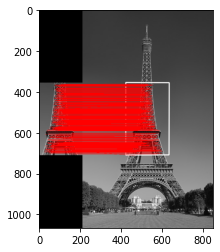

In [17]:
MIN_MATCH_COUNT = 10

# Compute SIFT keypoints and descriptors
des1 = generateDescriptors(keypoints1, blurs1)
des2 = generateDescriptors(keypoints2, blurs2)

# Initialize and use FLANN
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# Lowe's ratio test
good = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good.append(m)

if len(good) > MIN_MATCH_COUNT:
    # Estimate homography between template and scene
    src_pts = np.float32([ keypoints1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    dst_pts = np.float32([ keypoints2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

    M = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)[0]

    # Draw detected template in scene image
    h, w = image1.shape
    pts = np.float32([[0, 0],
                      [0, h - 1],
                      [w - 1, h - 1],
                      [w - 1, 0]]).reshape(-1, 1, 2)
    dst = cv2.perspectiveTransform(pts, M)

    image2 = cv2.polylines(image2, [np.int32(dst)], True, 255, 3, cv2.LINE_AA)

    h1, w1 = image1.shape
    h2, w2 = image2.shape
    print("img1: ", h1, w1)
    print("img2: ", h2, w2)

    nWidth = w1 + w2
    nHeight = max(h1, h2)
    hdif = int((h2 - h1) / 2)
    newimg = np.zeros((nHeight, nWidth, 3), np.uint8)

    for i in range(3):
        newimg[hdif:hdif + h1, :w1, i] = image1
        newimg[:h2, w1:w1 + w2, i] = image2

    # Draw SIFT keypoint matches
    for m in good:
        pt1 = (int(keypoints1[m.queryIdx].pt[0]), int(keypoints1[m.queryIdx].pt[1] + hdif))
        pt2 = (int(keypoints2[m.trainIdx].pt[0] + w1), int(keypoints2[m.trainIdx].pt[1]))
        cv2.line(newimg, pt1, pt2, (255, 0, 0))

    plt.imshow(newimg)
    plt.show()
else:
    print("Not enough matches are found - %d/%d" % (len(good), MIN_MATCH_COUNT))